<a href="https://colab.research.google.com/github/ecandes/stat318/blob/master/Swendsen_Wang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sampling from the Ising model via the Swendsen-Wang algorithm

We wish to sample from the Ising model 

$$
\pi(x) = \frac{1}{Z} \exp(-\beta E(x)) \qquad E(x) = - \sum_{v \sim v'} x_v x_{v'} 
$$

defined on a graph $G$, where $v \sim v'$ means that the nodes are adjacent. In the energy functional above, each edge is coounted only once. With this formulation, the critical value of $\beta$ is 

$$
\beta_c = \log(1+\sqrt{2}) \approx 0.8813
$$

We consider the Swendsen Wang algorithm to do this. We augment the data with bond variables and perform the following update:

- (1) Conditional on a spin configuration $x$, sample bond variables as follows: for each edge $e = (v,v')$, sample a bond variable $b_e$ with 

$$
b_e = \begin{cases} 1 & \text{wp. } 1-e^{-2\beta} \\
0 & \text{wp. } e^{-2\beta}
\end{cases} \qquad \text{if } x_v = x_{v'}
$$

and 

$$
b_e = 0 \qquad \text{if } x_v \neq x_{v'}. 
$$

- (2) Conditional on a bond configurations, update spins by sampling uniformly on all possible configurations; That is, assign i.i.d. $\pm 1$ variables to each cluster. 

In [0]:
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

plt.rcParams["figure.figsize"] = (4,4)

We work with the square lattice for our graph $G$ represented below. 

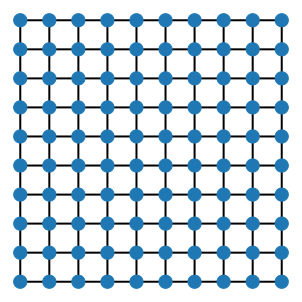

In [2]:
plt.rcParams["figure.figsize"] = (4,4)
L = 10
G = nx.grid_2d_graph(L,L)
pos = dict(zip(G.nodes.keys(),G.nodes.keys()))
options = {'node_size': 175, 'alpha' : 1, 'width' : 2}
nx.draw(G,pos,**options)

Consider a subgraph obtained by removing edges, this will create disconnected components as shown below.

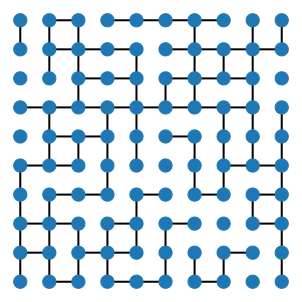

In [3]:
# Remove a fraction of the edges at random
nedges = G.number_of_edges()
U = np.random.rand(nedges) > 0.6
ebunch = [e for e,u in zip(G.edges,U) if u]
G.remove_edges_from(ebunch)
nx.draw(G,pos,**options)

Visualize clusters



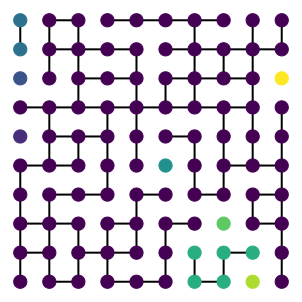

In [4]:
colors = dict.fromkeys(G.nodes())
val = 0
for c in nx.connected_components(G):
  for v in c:
     colors[v] = val
  val +=1

plt.rcParams["figure.figsize"] = (4,4)
nx.draw(G, pos, node_color = list(colors.values()),**options)

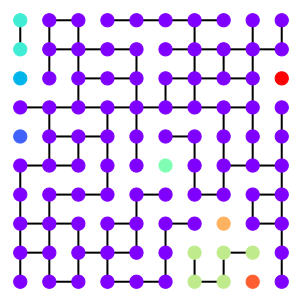

In [5]:
# Different color scheme
nx.draw(G, pos, node_color = list(colors.values()), cmap = plt.cm.get_cmap('rainbow'),**options)

In [0]:
class IsingModel:

    def __init__(self, G, X=None):
        self.G = G                   # Underlying graph
        self.n = G.number_of_nodes()  # Number of nodes
        self.nodes = list(G.nodes.keys())  # List of nodes
        if X is None:
            X = np.ones(self.n).astype(int)
        self.X = dict(zip(self.nodes, X))
        # Useful for plotting
        self.pos = dict(zip(self.nodes, self.nodes))

    def randomBit(self,p):
       return np.random.binomial(1, p, size=1)[0]

    def updateBonds(self,beta):
      ebonds = []
      for e in self.G.edges:
        if (self.X[e[0]] == self.X[e[1]] and self.randomBit(1-np.exp(-2*beta)) == 1):
          ebonds.append(e) 
      return ebonds 

    def updateSpins(self,beta):
      ebonds = self.updateBonds(beta)
      G = nx.Graph()
      G.add_nodes_from(self.G)
      G.add_edges_from(ebonds)

      for c in nx.connected_components(G):
        val = 2*self.randomBit(1/2)-1
        for v in c:
          self.X[v] = val

    def sum(self):
        return np.array(list(self.X.values())).sum()
  
    def drawConfig(self, node_size=150):
        plt.rcParams["figure.figsize"] = (4,4)
        up = [key for key in self.X.keys() if self.X[key] == 1]
        down = [key for key in self.X.keys() if self.X[key] == -1]
        nx.draw(G, self.pos, nodelist=up,   node_color="b", **options)
        nx.draw(G, self.pos, nodelist=down, node_color="r", **options)
        plt.title('Ising model configuration')
        plt.show()

    def sample(self, T, beta =1, X0=None):
        if not X0 is None:
            self.X = X0
        for t in range(T):
          self.updateSpins(beta)
                   

Let us check a sample after 100 iterations at 

$$
\text{Temperature} = 2 T_c
$$

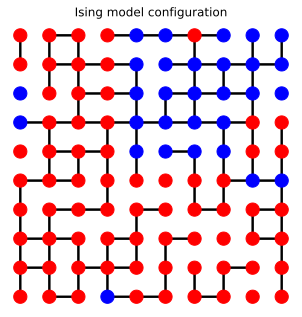

Magnetization at T = 100: -40
CPU times: user 435 ms, sys: 114 ms, total: 549 ms
Wall time: 443 ms


In [8]:
%%time 
beta_crit = np.log(1+np.sqrt(2))

beta = 0.5*beta_crit
T = 100

chain = IsingModel(nx.grid_2d_graph(L,L))
chain.sample(T,beta)
chain.drawConfig()
print('Magnetization at T = {}: {}'.format(T,chain.sum()))

## Magnetization

We are interested in the distribution of the magnetization $M$ defined as 

$$
M =  f(x) = \sum_v x_v.
$$

We generate a number of samples by running the chain and getting a realization every $T = 100$ time steps. 




In [0]:
def empiricalMagnetization(beta=1,T=100,nsamples=500):
  chain = IsingModel(nx.grid_2d_graph(L,L))
  magnetization = np.zeros(nsamples)
  for b in range(nsamples):
    chain.sample(T,beta)
    magnetization[b] = chain.sum()
  
  plt.rcParams["figure.figsize"] = (6,6)
  plt.hist(magnetization)
  plt.title('Magnetization')
  plt.show()
  return magnetization

### Lukewarm temperature: Temp = 4 $T_c$

We start with a lukewarm temperature set to 

$$
\text{Temperature} = 1/\beta = 4 T_c
$$

and show the empirical distribution of magnetization.

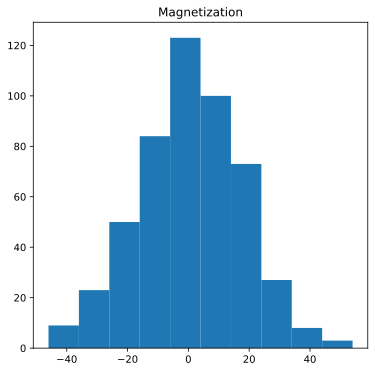

CPU times: user 1min 27s, sys: 178 ms, total: 1min 28s
Wall time: 1min 27s


In [10]:
%%time
magnetization = empiricalMagnetization(beta=1/4*beta_crit)

### Same thing at a colder temperature

We go with an even colder temperature set to

$$
\text{Temperature} = 1.66 T_c
$$

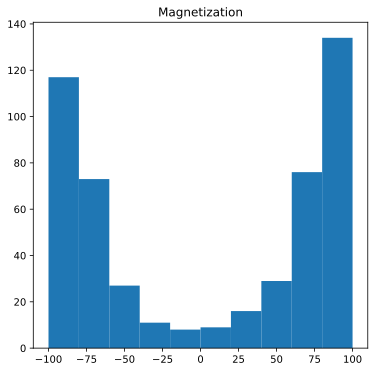

CPU times: user 1min 32s, sys: 230 ms, total: 1min 32s
Wall time: 1min 32s


In [18]:
%%time
magnetization = empiricalMagnetization(beta=0.6*beta_crit)

### Same thing at critcal temperature

We go with an even colder temperature set to

$$
\text{Temperature} = T_c
$$

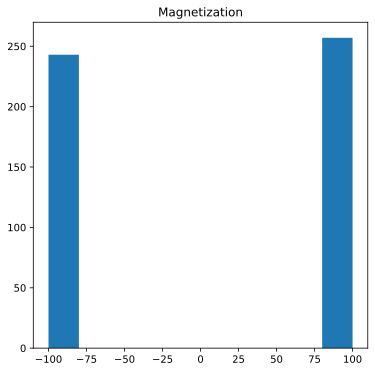

[  98.  100. -100. -100. -100.  -98.  -98.  100.  -96.  -96.   90.  100.
  100.  100.  100.  -96.  100. -100.  100.  100. -100.  100.  -96. -100.
   98.  -98. -100. -100. -100.  -98.  -98.   98.  100. -100. -100. -100.
 -100.   92.   94.   98.  -88. -100. -100.  100.   98.   98.  100.  100.
  -96.  -98.  100.  -98.  100. -100. -100.  100. -100.   98. -100.  100.
 -100. -100.  100. -100. -100.  100.  100. -100.   96.  100. -100. -100.
  100. -100. -100.   98.  -98.  100. -100. -100. -100.   98.   96.  -94.
  100.   98.  100. -100.   98.   98. -100.  100.   98.  100.   98.  -96.
  -98.   98.   98.   98. -100. -100.  100. -100.  -96.  100. -100.  100.
  100.  -98. -100.  100.   96.   94.   96. -100.  100.   98.   98.  100.
  100.  100. -100.  -98.  -96.  100.  100.   98.  100.  -92.  -98.  100.
 -100.  -98.  -96.  -98.  -98. -100.  100.  -96.  100.  -98.  100.  100.
  100. -100. -100.   98.   96.  100.  100. -100.  -98.   96.  -96.  100.
 -100.  100.   96.   98. -100.   98. -100. -100.  -

In [19]:
%%time
magnetization = empiricalMagnetization(beta=beta_crit)
print(magnetization)